In [1]:
# Cell 1 — only install what’s missing, skip torch/torchvision
!pip install --quiet ultralytics opencv-python-headless scipy matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00:00:0100:01


In [2]:
import cv2, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from ultralytics import YOLO
import torch, torchvision
import torchvision.transforms as T
from scipy.spatial import distance
from IPython.display import HTML

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", DEVICE)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


(-0.5, 1919.5, 1079.5, -0.5)

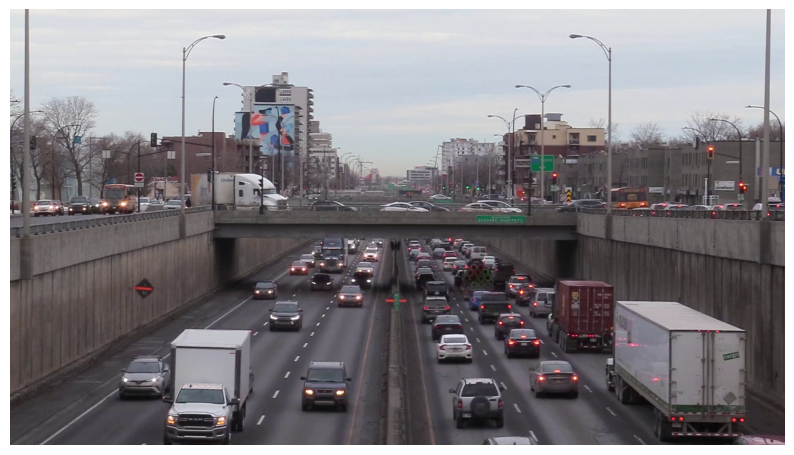

In [3]:
video_path = '/kaggle/input/highway/3727445-hd_1920_1080_30fps.mp4'  # adjust path
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()

# Convert BGR→RGB and show
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,6))
plt.imshow(frame_rgb)
plt.axis('off')


In [4]:
# e.g. x=100, y=200, w=800, h=400
ROI = (100, 200, 800, 400)


In [5]:
# Cell X: Define COCO class names for R-CNN
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [6]:
# Cell Y: Faster R-CNN detection
import torchvision
import torchvision.transforms as T

# Load model
rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
rcnn_model = rcnn_model.to(DEVICE).eval()
transform = T.Compose([T.ToTensor()])

def detect_rcnn(frame, roi, threshold=0.5):
    x, y, w, h = map(int, roi)
    crop = frame[y:y+h, x:x+w]
    img = transform(crop).to(DEVICE)
    outputs = rcnn_model([img])[0]
    detections = []
    for box, label, score in zip(outputs['boxes'], outputs['labels'], outputs['scores']):
        if score >= threshold:
            x1, y1, x2, y2 = map(int, box.cpu())
            detections.append({
                'bbox': [x1 + x, y1 + y, x2 + x, y2 + y],
                'label': COCO_INSTANCE_CATEGORY_NAMES[label],
                'conf': float(score.cpu())
            })
    return detections


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 203MB/s]  


In [7]:
class CentroidTracker:
    def __init__(self, max_dist=50):
        self.nextID, self.objects, self.disp = 0, {}, {}
        self.max_dist, self.counted = max_dist, set()
        self.counts = {'car':0,'motorcycle':0,'truck':0}
    def register(self, c): self.objects[self.nextID]=c; self.disp[self.nextID]=0; self.nextID+=1
    def dereg(self,i): del self.objects[i]; del self.disp[i]
    def update(self,dets):
        in_c,labels = [],[]
        for d in dets:
            if d['label'] in self.counts:
                x1,y1,x2,y2 = d['bbox']
                in_c.append(((x1+x2)//2,(y1+y2)//2))
                labels.append(d['label'])
        if not self.objects:
            for c in in_c: self.register(c)
            return self.counts
        IDs = list(self.objects); C = list(self.objects.values())
        D = distance.cdist(C, in_c)
        rows = D.min(axis=1).argsort(); cols = D.argmin(axis=1)[rows]
        usedR, usedC = set(), set()
        for r,c in zip(rows,cols):
            if r in usedR or c in usedC or D[r,c]>self.max_dist: continue
            oid=IDs[r]; self.objects[oid]=in_c[c]; self.disp[oid]=0
            if oid not in self.counted:
                self.counted.add(oid); self.counts[labels[c]]+=1
            usedR.add(r); usedC.add(c)
        for r in set(range(len(C)))-usedR:
            oid=IDs[r]; self.disp[oid]+=1
            if self.disp[oid]>5: self.dereg(oid)
        for c in set(range(len(in_c)))-usedC:
            self.register(in_c[c])
        return self.counts

class SpeedEstimator:
    def __init__(self,fps): self.fps=fps; self.prev={}
    def estimate(self, objs):
        spd = {}
        for oid,c in objs.items():
            if oid in self.prev:
                dx,dy = c[0]-self.prev[oid][0], c[1]-self.prev[oid][1]
                d_ft = np.hypot(dx/8, dy/20)
                spd[oid] = ((d_ft*0.3048)/(1/self.fps))*3.6
            self.prev[oid]=c
        return spd


In [8]:
model = YOLO('yolov8n.pt')  # Or your trained weights

def detect_yolo(frame, roi=None):
    results = model(frame)[0]
    detections = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0])
        label = model.names[cls_id]

        # Apply ROI filtering
        if roi:
            rx1, ry1, rx2, ry2 = roi
            if not (rx1 <= x1 <= rx2 and ry1 <= y1 <= ry2):
                continue

        detections.append({
            'bbox': [x1, y1, x2, y2],
            'label': label,
            'conf': conf
        })

    return detections


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.3MB/s]


In [ ]:
def process_and_save(video_path, detector, roi, out_path, use_speed=True):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    w,h = int(cap.get(3)), int(cap.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_path, fourcc, fps, (w,h))

    tracker = CentroidTracker()
    estimator = SpeedEstimator(fps) if use_speed else None

    while True:
        ret,frame = cap.read()
        if not ret: break
        dets = detector(frame, roi)
        counts = tracker.update(dets)
        speeds = estimator.estimate(tracker.objects) if use_speed else {}
        # draw
        for d in dets:
            x1,y1,x2,y2 = d['bbox']
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
            cv2.putText(frame,f"{d['label']} {d['conf']:.2f}",(x1,y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,0),2)
        for oid,spd in speeds.items():
            x,y = tracker.objects[oid]
            col = (0,0,255) if spd>30 else (0,255,0)
            cv2.putText(frame,f"{spd:.1f} km/h",(x-20,y),
                        cv2.FONT_HERSHEY_SIMPLEX,0.5,col,2)
        # counts overlay
        cv2.putText(frame,f"Cars: {counts['car']}",(10,30),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(frame,f"Motorcycles: {counts['motorcycle']}",(10,60),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        cv2.putText(frame,f"Trucks: {counts['truck']}",(10,90),
                    cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)

        writer.write(frame)
    cap.release(); writer.release()
    return counts

# Run and save
out = '/kaggle/working/output.mp4'
_ = process_and_save(video_path, detect_yolo, ROI, out)



0: 384x640 18 cars, 4 trucks, 50.2ms
Speed: 7.8ms preprocess, 50.2ms inference, 263.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 cars, 1 bus, 5 trucks, 7.9ms
Speed: 2.9ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 5 trucks, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 6 trucks, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 1 bus, 5 trucks, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 cars, 1 bus, 4 trucks, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 cars, 2 buss, 4 trucks, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 cars, 2 buss, 3 truck

In [ ]:
# Point these to where your files actually sit in Kaggle
VIDEO_PATH   = '/kaggle/working/highway.mp4'                # your uploaded video
WEIGHTS_PATH = '/kaggle/working/yolov8n.pt'  # your custom .pt
OUTPUT_PATH  = '/kaggle/working/output_custom.mp4'          # where to save results


In [ ]:
from ultralytics import YOLO

# overwrite the earlier model
yolo_model = YOLO(WEIGHTS_PATH).to(DEVICE)


In [ ]:
def process_and_save(video_path, detector, roi, out_path, use_speed=True):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

    tracker   = CentroidTracker()
    estimator = SpeedEstimator(fps) if use_speed else None

    # Initialize counts to avoid UnboundLocalError
    counts = tracker.counts.copy()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        dets   = detector(frame, roi)
        counts = tracker.update(dets)               # will always assign
        speeds = estimator.estimate(tracker.objects) if use_speed else {}

        # Draw detections, counts & speeds (as before)…
        for d in dets:
            x1, y1, x2, y2 = d['bbox']
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(frame, f"{d['label']} {d['conf']:.2f}", 
                        (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

        cv2.putText(frame, f"Cars: {counts['car']}", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(frame, f"Motorcycles: {counts['motorcycle']}", (10,60),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(frame, f"Trucks: {counts['truck']}", (10,90),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

        for oid, spd in speeds.items():
            cx, cy = tracker.objects[oid]
            color = (0,0,255) if spd > 30 else (0,255,0)
            cv2.putText(frame, f"{spd:.1f} km/h", (cx-20, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            cv2.circle(frame, (cx, cy), 4, color, -1)

        writer.write(frame)

    cap.release()
    writer.release()
    return counts
